# Challenge 02 - OpenAI Models & Capabilities

In this challenge, you will learn about the different capabilities of OpenAI models and learn how to choose the best model for your use case.

You are going to compare gpt3.5 to gpt4 model in this challenge. If you do not have gpt-4 access, you can compare the legacy models if they are deployed, or go through this challenge conceptually to understand how to best pick a model from the ones you have deployed as well as the ones in the model catalog.

In a world where the availability and development of models are always changing, the model we compare may change over time. But we encourage you to understand the general concepts and material in this Challenge because the comparison techniques utilized can be applicable to scenarios where you are comparing Large Language Models.


Questions you will be able to answer by the end of this challenge:

* How do responses differ for each model?
* What are ways to benchmark the performance of models? 

## 1. Overview on finding the right model for you



### 1.1 Model Families

Azure OpenAI provides access to many different models, grouped by family and capability. A model family typically associates models by their intended task. 

Model families currently available as of _Dec 1, 2023_ in Azure OpenAI includes GPT-4, GPT-3.5, Embeddings, DALL-E, and Whisper. Please reference this link for more information: https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models

For GPT-3 and other models retiring in July 2024, see [Azure OpenAI Service legacy models](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/legacy-models)


### 1.2 Model Capacities
#### GPT-4
GPT-4 can solve difficult problems with greater accuracy than any of OpenAI's previous models. Like GPT-3.5 Turbo, GPT-4 is optimized for chat and works well for traditional completions tasks. Use the Chat Completions API to use GPT-4.

#### GPT-3.5
GPT-3.5 models can understand and generate natural language or code. The most capable and cost effective model in the GPT-3.5 family is GPT-3.5 Turbo, which has been optimized for chat and works well for traditional completions tasks as well. GPT-3.5 Turbo is available for use with the Chat Completions API. GPT-3.5 Turbo Instruct has similar capabilities to text-davinci-003 using the Completions API instead of the Chat Completions API. We recommend using GPT-3.5 Turbo and GPT-3.5 Turbo Instruct over legacy GPT-3.5 and GPT-3 models.

`gpt-35-turbo`

`gpt-35-turbo-16k`

`gpt-35-turbo-instruct`

You can see the token context length supported by each model in the [model summary table](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#model-summary-table-and-region-availability).

#### Embeddings 
The previous embeddings models have been consolidated into the following new replacement model:

`text-embedding-ada-002`


[Azure OpenAI models](https://learn.microsoft.com/en-us/azure/cognitive-services/openai/concepts/models)  


| Models | Description |
| --- | --- |
| GPT-4 | A set of models that improve on GPT-3.5 and can understand and generate natural language and code. | 
| GPT-3.5 | A set of models that improve on GPT-3 and can understand and generate natural language and code. | 
| Embeddings | A set of models that can convert text into numerical vector form to facilitate text similarity. | 


### 1.3 Pricing Details

For the most up-to-date information, check out the Azure OpenAI [pricing page](https://azure.microsoft.com/en-us/pricing/details/cognitive-services/openai-service/).



### 1.4 Quotas and Limits

*The below limits are subject to change. We anticipate that you will need higher limits as you move toward production and your solution scales. When you know your solution requirements, please reach out to us by applying for a quota increase here: https://aka.ms/oai/quotaincrease

|Limit Name	|Limit Value|
|---|---|
|OpenAI resources per region per Azure subscription|	30|
| Default DALL-E 2 quota limits| 2 concurrent requests |
| Default DALL-E 3 quota limits  | 2 capacity units (6 requests per minute)|
|Maximum prompt tokens per request| Varies per model, see [Azure OpenAI Service models](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models) |
|Max fine-tuned model deployments|5|
|Total number of training jobs per resource|	100|
|Max simultaneous running training jobs per resource|	1|
|Max training jobs queued	|20|
|Max Files per resource	|30|
|Total size of all files per resource	|1 GB|
|Max training job time (job will fail if exceeded)	|720 hours|
|Max training job size (tokens in training file) x (# of epochs)	|2 Billion|
|Max size of all files per upload (Azure OpenAI on your data)	|16 MB|

### 1.5 Model Selection

Here is some general guidance on well-suited scenarios that tend to differentiate models. Note that these are not hard and fast rules, and oftentimes experimentation and benchmarking are important to making the best decision for your solution.

|Model|Use Cases|
|---|---|
|GPT-3.5| Faster/cheaper app performance; <br/>More quota allocated by default|
|GPT-4| More advanced reasoning or logical processing needed; <br/> 32k token window is an absolut must; <br/>Multilingual proficiency needed; <br/>No hard requirement on low latency|


### 1.6 Model Selection Best Practices
Our recommendation is for users to start with GPT-3.5 Turbo if identify with the use case listed above, and move to GPT-4 if needed.

Once you have a prototype working, you can then optimize your model choice with the best latency/performance balance for your application.

## 2. Let's Start Implementation

If you don't already have the OpenAI, Python-dotenv, plotly, or scikit-learn packages installed on your compute, the following cells will install them.

In [35]:
import openai
import os
import json
from dotenv import load_dotenv, find_dotenv
import pandas as pd
load_dotenv(find_dotenv())


True

Set up your environment to access your OpenAI keys. Refer to your OpenAI resource in the Azure Portal to retrieve information regarding your OpenAI endpoint and keys.

For security purposes, store your sensitive information in a .env file.

In [36]:
API_KEY = os.getenv("OPENAI_API_KEY")
assert API_KEY, "ERROR: Azure OpenAI Key is missing"
openai.api_key = API_KEY

RESOURCE_ENDPOINT = os.getenv("OPENAI_API_BASE","").strip()
assert RESOURCE_ENDPOINT, "ERROR: Azure OpenAI Endpoint is missing"
assert "openai.azure.com" in RESOURCE_ENDPOINT.lower(), "ERROR: Azure OpenAI Endpoint should be in the form: \n\n\t<your unique endpoint identifier>.openai.azure.com"

openai.api_base = RESOURCE_ENDPOINT
openai.api_type = os.getenv("OPENAI_API_TYPE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

chat_model=os.getenv("CHAT_MODEL_NAME")
chat_model2=os.getenv("CHAT_MODEL_NAME2")





### 2.0 Helper Functions
Throughout this course, we will use OpenAI's `gpt-3.5-turbo` and `gpt-4` models and the [chat completions endpoint](https://platform.openai.com/docs/guides/chat). 

This helper function will make it easier to use prompts and look at the generated outputs.

**timer wrapper** helps us monitor and compare the latency of each model.

**get_chat_completion** helps create the OpenAI response using the chat model of your choice.

**get_completion_from_messages** helps create the OpenAI response using the chat model of your choice, enabling chat history.


In [8]:
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        value = func(*args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print("Finished {} in {} secs".format(repr(func.__name__), round(run_time, 3)))
        return value[0], value[1], round(run_time, 3)

    return wrapper

In [9]:
@timer
def get_chat_completion(prompt, model):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        engine=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
        max_tokens = 200,
        top_p = 1.0,
    )
    return response.choices[0].message["content"],response['usage']['total_tokens']


In [10]:
@timer
def get_completion_from_messages(messages, model, temperature=0):
    response = openai.ChatCompletion.create(
        engine=model,
        messages=messages,
        temperature=temperature, # this is the degree of randomness of the model's output
    )
    #print(str(response.choices[0].message))
    return response.choices[0].message["content"],response['usage']['total_tokens']


### 2.1 Summarize Text

In [11]:
model_pricing = pd.DataFrame(columns=['task','model', 'price', 'time'])
pricing = model_pricing

In [12]:


text = f"""
The Olympic Games Tokyo 2020 reached a global broadcast audience of 3.05 billion people, according to independent research conducted on behalf of the International Olympic Committee (IOC). Official coverage on Olympic broadcast partners\' digital platforms alone generated 28 billion video views in total – representing a 139 per cent increase compared with the Olympic Games Rio 2016 and underlining the changing media landscape and Tokyo 2020\'s designation as the first streaming Games and the most watched Olympic Games ever on digital platforms.Sony and Panasonic partnered with NHK to develop broadcasting standards for 8K resolution television, with a goal to release 8K television sets in time for the 2020 Summer Olympics. In early 2019, Italian broadcaster RAI announced its intention to deploy 8K broadcasting for the Games. NHK broadcast the opening and closing ceremonies, and coverage of selected events in 8K. Telecom company NTT Docomo signed a deal with Finland\'s Nokia to provide 5G-ready baseband networks in Japan in time for the Games.The Tokyo Olympics were broadcast in the United States by NBCUniversal networks, as part of a US$4.38 billion agreement that began at the 2014 Winter Olympics in Sochi. The United States Olympic & Paralympic Committee asserted that a "right of abatement" clause in the contract was triggered by the delay of the Games to 2021, requiring the IOC to "negotiate in good faith an equitable reduction in the applicable broadcast rights payments" by NBC, which remains one of IOC\'s biggest revenue streams. According to NBCUniversal CEO Jeff Shell, the Tokyo games could be the most profitable Olympics in NBC\'s history. The Tokyo games were NBC\'s first Olympics broadcast under current president Susan Rosner Rovner.In Europe, this was the first Summer Olympics under the IOC\'s exclusive pan-European rights deal with Eurosport, which began at the 2018 Winter Olympics and is contracted to run through 2024. The rights for the 2020 Summer Olympics covered almost all of Europe; a pre-existing deal with a marketer excludes Russia. Eurosport planned to sub-license coverage to free-to-air networks in each territory, and other channels owned by Discovery, Inc. subsidiaries. In the United Kingdom, these were set to be the last Games with rights owned primarily by the BBC, although as a condition of a sub-licensing agreement due to carry into the 2022 and 2024 Games, Eurosport holds exclusive pay television rights. In France, these were the last Games whose rights are primarily owned by France Télévisions. Eurosport debuted as pay television rightsholder, after Canal+ elected to sell its pay television rights as a cost-saving measure.In Canada, the 2020 Games were shown on CBC/Radio-Canada platforms, Sportsnet, TSN and TLN. In Australia, they were aired by Seven Network. In the Indian subcontinent, they were aired by Sony Pictures Networks India (SPN).
"""
prompt = f"""
Summarize the text delimited by triple backticks into a single sentence.
```{text}```
"""

gpt35_response, gpt35_price, gpt35_time = get_chat_completion(prompt, model=chat_model)
gpt4_response, gpt4_price, gpt4_time = get_chat_completion(prompt, model=chat_model2)

print(f"GPT-3.5 Response: {gpt35_response}\n")
print(f"GPT-4 Response: {gpt4_response}\n")

task = '2.1'
new_rows = pd.DataFrame([{'task': task, 'model': 'gpt3.5', 'price': gpt35_price, 'time': gpt35_time},
                         {'task': task, 'model': 'gpt4','price': gpt4_price, 'time': gpt4_time}])
pricing = pd.concat([pricing, new_rows], ignore_index=True)


print(pricing)


Finished 'get_chat_completion' in 0.667 secs
Finished 'get_chat_completion' in 3.81 secs
GPT-3.5 Response: The Olympic Games Tokyo 2020 had a global broadcast audience of 3.05 billion people, with official coverage on digital platforms generating 28 billion video views, and the Games were broadcast by various networks around the world including NBCUniversal, Eurosport, CBC/Radio-Canada, and Sony Pictures Networks India.

GPT-4 Response: The Tokyo 2020 Olympics reached a global audience of 3.05 billion people, with digital platforms generating 28 billion video views, marking a 139% increase from the Rio 2016 Olympics and making it the most-watched Olympics on digital platforms; the event also saw the development of 8K broadcasting standards and 5G-ready networks, and was broadcast by various networks worldwide, including NBCUniversal in the US, Eurosport in Europe, and CBC/Radio-Canada in Canada.

  task   model price   time
0  2.1  gpt3.5   693  0.667
1  2.1    gpt4   731  3.810


/tmp/ipykernel_1271/3850046144.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pricing = pd.concat([pricing, new_rows], ignore_index=True)


#### Student Task #1:
With tactics learned in CH1, edit the prompt to get more concise answer from the assistant. Do you find any difference in the result?

In [13]:
# edit the prompt to get more concise answer from assistant
prompt = f"""
Summarize the text into a short single sentence.
```{text}```
"""

gpt35_response, gpt35_price, gpt35_time = get_chat_completion(prompt, model=chat_model)
gpt4_response, gpt4_price, gpt4_time = get_chat_completion(prompt, model=chat_model2)


print(f"GPT-3.5 Response: {gpt35_response}\n")
print(f"GPT-4 Response: {gpt4_response}\n")

task = 'ST.1'
new_rows = pd.DataFrame([{'task': task, 'model': 'gpt3.5', 'price': gpt35_price, 'time': gpt35_time},
                         {'task': task, 'model': 'gpt4','price': gpt4_price, 'time': gpt4_time}])
pricing = pd.concat([pricing, new_rows], ignore_index=True)

print(pricing)


Finished 'get_chat_completion' in 0.37 secs
Finished 'get_chat_completion' in 2.243 secs
GPT-3.5 Response: The Tokyo 2020 Olympic Games had a global broadcast audience of 3.05 billion people, with a significant increase in digital platform views, and were broadcast by various media companies around the world.

GPT-4 Response: The Tokyo 2020 Olympics reached a global audience of 3.05 billion people, with digital platforms generating 28 billion video views, marking a 139% increase from the Rio 2016 Olympics and making it the most-watched Olympics ever on digital platforms.

   task   model price   time
0   2.1  gpt3.5   693  0.667
1   2.1    gpt4   731  3.810
2  ST.1  gpt3.5   666  0.370
3  ST.1    gpt4   680  2.243


### 2.2 Summarization for a targeted audience

In [14]:
prompt = f"""
Summarize the text delimited by triple backticks into a single sentence for 7-year-old to understand.
```{text}```
"""


gpt35_response, gpt35_price, gpt35_time = get_chat_completion(prompt, model=chat_model)
gpt4_response, gpt4_price, gpt4_time = get_chat_completion(prompt, model=chat_model2)

print(f"GPT-3.5 Response: {gpt35_response}\n")
print(f"GPT-4 Response: {gpt4_response}\n")


task = '2.2'
new_rows = pd.DataFrame([{'task': task, 'model': 'gpt3.5', 'price': gpt35_price, 'time': gpt35_time},
                         {'task': task, 'model': 'gpt4','price': gpt4_price, 'time': gpt4_time}])
pricing = pd.concat([pricing, new_rows], ignore_index=True)

print(pricing)


Finished 'get_chat_completion' in 0.287 secs
Finished 'get_chat_completion' in 2.103 secs
GPT-3.5 Response: The Olympic Games in Tokyo were watched by a lot of people all over the world, and many different companies and TV networks showed the games on their channels.

GPT-4 Response: The Tokyo 2020 Olympics was watched by over 3 billion people worldwide, with lots of people watching online, making it the most watched Olympics ever on digital platforms.

   task   model price   time
0   2.1  gpt3.5   693  0.667
1   2.1    gpt4   731  3.810
2  ST.1  gpt3.5   666  0.370
3  ST.1    gpt4   680  2.243
4   2.2  gpt3.5   668  0.287
5   2.2    gpt4   671  2.103


#### Student Challenge #2:
Edit the prompt to summarize the text for eye-catching newspaper title. Compare different results.

In [15]:
# Edit the prompt to summarize the text for eye-catching newspaper title

prompt = f"""
Summarize the text delimited by triple backticks into a "breaking news" style setence with 10 words.
```{text}```
"""

gpt35_response, gpt35_price, gpt35_time = get_chat_completion(prompt, model=chat_model)
gpt4_response, gpt4_price, gpt4_time = get_chat_completion(prompt, model=chat_model2)

print(f"GPT-3.5 Response: {gpt35_response}\n")
print(f"GPT-4 Response: {gpt4_response}\n")


task = 'ST.2'
new_rows = pd.DataFrame([{'task': task, 'model': 'gpt3.5', 'price': gpt35_price, 'time': gpt35_time},
                         {'task': task, 'model': 'gpt4','price': gpt4_price, 'time': gpt4_time}])
pricing = pd.concat([pricing, new_rows], ignore_index=True)
print(pricing)

Finished 'get_chat_completion' in 0.24 secs
Finished 'get_chat_completion' in 1.301 secs
GPT-3.5 Response: Tokyo 2020 Olympics reached 3.05 billion viewers, most watched ever.

GPT-4 Response: Tokyo 2020 Olympics reached record 3.05 billion global audience, marking a 139% increase in digital views from Rio 2016.

   task   model price   time
0   2.1  gpt3.5   693  0.667
1   2.1    gpt4   731  3.810
2  ST.1  gpt3.5   666  0.370
3  ST.1    gpt4   680  2.243
4   2.2  gpt3.5   668  0.287
5   2.2    gpt4   671  2.103
6  ST.2  gpt3.5   657  0.240
7  ST.2    gpt4   670  1.301


### 2.3 Summarize Cause & Effect

In [16]:
prompt = f"""
Summarize the major event's cause and effect for the text delimited by triple backticks into a single sentence less than 50 words.
```{text}```
"""


gpt35_response, gpt35_price, gpt35_time = get_chat_completion(prompt, model=chat_model)
gpt4_response, gpt4_price, gpt4_time = get_chat_completion(prompt, model=chat_model2)

print(f"GPT-3.5 Response: {gpt35_response}\n")
print(f"GPT-4 Response: {gpt4_response}\n")


task = '2.3'
new_rows = pd.DataFrame([{'task': task, 'model': 'gpt3.5', 'price': gpt35_price, 'time': gpt35_time},
                         {'task': task, 'model': 'gpt4','price': gpt4_price, 'time': gpt4_time}])
pricing = pd.concat([pricing, new_rows], ignore_index=True)
print(pricing)

Finished 'get_chat_completion' in 0.455 secs
Finished 'get_chat_completion' in 2.988 secs
GPT-3.5 Response: The cause of the major event was the global broadcast audience of 3.05 billion people for the Olympic Games Tokyo 2020, with significant increases in digital platform views, the development of 8K broadcasting standards, and the negotiation of broadcast rights payments.

GPT-4 Response: The Tokyo 2020 Olympics reached a global audience of 3.05 billion people, with digital platforms generating 28 billion video views, a 139% increase from the Rio 2016 Olympics, making it the most-watched Olympics on digital platforms due to advancements in broadcasting technology and strategic partnerships.

   task   model price   time
0   2.1  gpt3.5   693  0.667
1   2.1    gpt4   731  3.810
2  ST.1  gpt3.5   666  0.370
3  ST.1    gpt4   680  2.243
4   2.2  gpt3.5   668  0.287
5   2.2    gpt4   671  2.103
6  ST.2  gpt3.5   657  0.240
7  ST.2    gpt4   670  1.301
8   2.3  gpt3.5   695  0.455
9   2.

#### Student Task #3: Model Comparison
Use the model comparison chart to briefly summarize your findings after comparing different model output & time taken. eg. GPT-4: Performance (+++), time (+). You may also leverage other python packages to visualize your findings.

|Model| Performance  |Time|
|---|---|---|
|GPT-3.5|||
|GPT-4|||



 #### Student Task #4: Text Classification
 Edit the prompt to make the models generate key topic categories for the text. Compare different model performance.

In [17]:
# Edit the prompt to make the models generate key topic categories for the text

prompt = f"""
Infer key topics of the story
```{text}```
"""


gpt35_response, gpt35_price, gpt35_time = get_chat_completion(prompt, model=chat_model)
gpt4_response, gpt4_price, gpt4_time = get_chat_completion(prompt, model=chat_model2)

print(f"GPT-3.5 Response: {gpt35_response}\n")
print(f"GPT-4 Response: {gpt4_response}\n")

task = 'ST.4'
new_rows = pd.DataFrame([{'task': task, 'model': 'gpt3.5', 'price': gpt35_price, 'time': gpt35_time},
                         {'task': task, 'model': 'gpt4','price': gpt4_price, 'time': gpt4_time}])
pricing = pd.concat([pricing, new_rows], ignore_index=True)
print(pricing)


Finished 'get_chat_completion' in 0.97 secs
Finished 'get_chat_completion' in 6.39 secs
GPT-3.5 Response: 1. Global broadcast audience of the Olympic Games Tokyo 2020
2. Digital platform viewership and the changing media landscape
3. Development of 8K resolution television for broadcasting the Games
4. Broadcasting partnerships and agreements with companies like Sony, Panasonic, NHK, NTT Docomo, and Nokia
5. Broadcast rights agreements and negotiations with NBCUniversal, Eurosport, BBC, France Télévisions, CBC/Radio-Canada, Seven Network, and Sony Pictures Networks India
6. Impact of the delay of the Games to 2021 on broadcast rights payments
7. Introduction of new pay television rightsholders like Eurosport and the debut of pay television rights for the Games in certain regions.

GPT-4 Response: 1. Tokyo 2020 Olympics global broadcast audience
2. Increase in digital viewership of the Olympics
3. Development of 8K resolution television for Olympics broadcasting
4. Broadcasting of Tokyo

#### Student Task #5:
Edit the prompt to make the models generate more precise results. Compare different model performance.

In [18]:
# Edit the prompt to make the models generate more precise results

prompt = f"""
Identify the major events causes and effects using numbers as facts and sorting by importance.
```{text}```
"""


gpt35_response, gpt35_price, gpt35_time = get_chat_completion(prompt, model=chat_model)
gpt4_response, gpt4_price, gpt4_time = get_chat_completion(prompt, model=chat_model2)

print(f"GPT-3.5 Response: {gpt35_response}\n")
print(f"GPT-4 Response: {gpt4_response}\n")


task = 'ST.5'
new_rows = pd.DataFrame([{'task': task, 'model': 'gpt3.5', 'price': gpt35_price, 'time': gpt35_time},
                         {'task': task, 'model': 'gpt4','price': gpt4_price, 'time': gpt4_time}])
pricing = pd.concat([pricing, new_rows], ignore_index=True)
print(pricing)
print(pricing)

Finished 'get_chat_completion' in 1.324 secs
Finished 'get_chat_completion' in 6.276 secs
GPT-3.5 Response: 1. The Olympic Games Tokyo 2020 reached a global broadcast audience of 3.05 billion people, making it the most watched Olympic Games ever on digital platforms.
2. Sony and Panasonic partnered with NHK to develop broadcasting standards for 8K resolution television, with a goal to release 8K television sets in time for the 2020 Summer Olympics.
3. The United States Olympic & Paralympic Committee triggered a "right of abatement" clause in the broadcast rights contract, requiring the IOC to negotiate a reduction in the applicable broadcast rights payments by NBC due to the delay of the Games to 2021.
4. The Tokyo Olympics were broadcast in the United States by NBCUniversal networks as part of a US$4.38 billion agreement, with the potential to be the most profitable Olympics in NBC's history.
5. This was the first Summer Olympics under the IOC's exclusive pan-European rights deal with

#### Student Challenge #6: Model Comparison

Write code to create two bar charts comparing the **price** and **time for completion** between the models. We recommend using the `matplotlib.pyplot` library for making visualizations.

Instructions for completion:

* Utilize the `model_comparison` dataframe to calculate the averages of price and time for each model
* Produce the bar chart in a currency amount. Note that the `price` column in the `model_comparison` dataframe is in the unit of tokens. Refer to the Azure [OpenAI pricing page](https://azure.microsoft.com/en-us/pricing/details/cognitive-services/openai-service/) to convert the units.

<Axes: xlabel='task'>

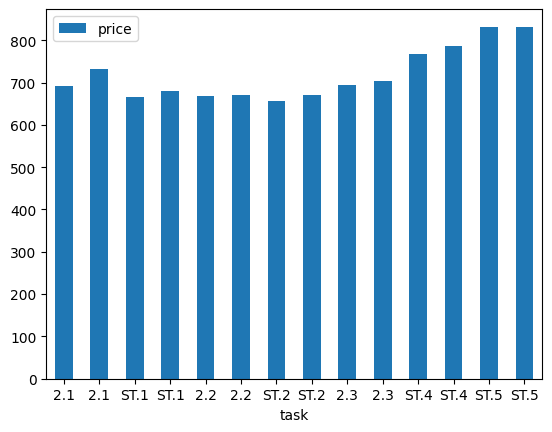

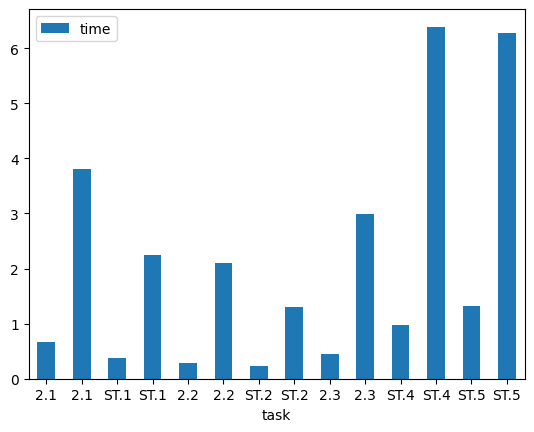

In [19]:
""" STUDENT CHALLENGE """

import matplotlib.pyplot as plt

### 1. Bar chart to compare pricing
## Plat pricing datagrame using matplotlib
pricing.plot.bar(x='task', y='price', rot=0)

### 2. Bar chart to compare time for completion
## Plat pricing datagrame using matplotlib
pricing.plot.bar(x='task', y='time', rot=0)


In [20]:
## Create a dictionary to store pricings in a tuple grouped by model
model_price = {}
for model in pricing['model'].unique():
    model_price[model] = tuple(pricing[pricing['model']==model]['price'].values.tolist())

model_time = {}
for model in pricing['model'].unique():
    model_time[model] = tuple(pricing[pricing['model']==model]['time'].values.tolist())

tasks = tuple(pricing[pricing['model']=='gpt4']['task'].values.tolist())

print(tasks)
print(model_time)

('2.1', 'ST.1', '2.2', 'ST.2', '2.3', 'ST.4', 'ST.5')
{'gpt3.5': (0.667, 0.37, 0.287, 0.24, 0.455, 0.97, 1.324), 'gpt4': (3.81, 2.243, 2.103, 1.301, 2.988, 6.39, 6.276)}


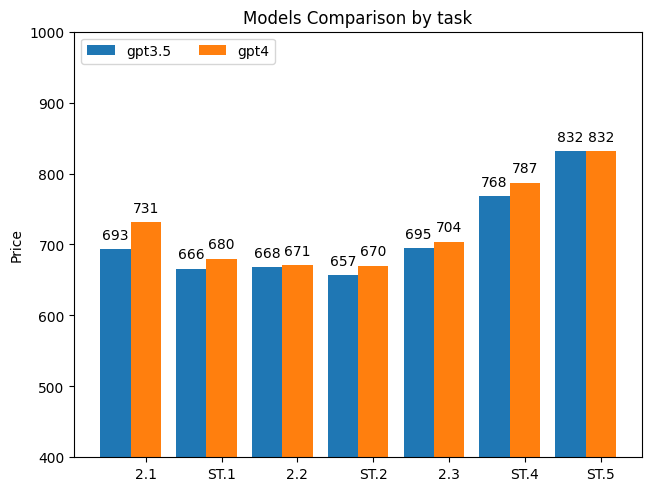

In [21]:

import matplotlib.pyplot as plt
import numpy as np

## Convert task column from pricing dataframe to tuple 
tasks = tuple(pricing[pricing['model']=='gpt4']['task'].values.tolist())

## Create a dictionary to store pricings in a tuple grouped by model
model_price = {}
for model in pricing['model'].unique():
    model_price[model] = tuple(pricing[pricing['model']==model]['price'].values.tolist())

x = np.arange(len(tasks))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in model_price.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price')
ax.set_title('Models Comparison by task')
ax.set_xticks(x + width, tasks)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(400, 1000)

plt.show()




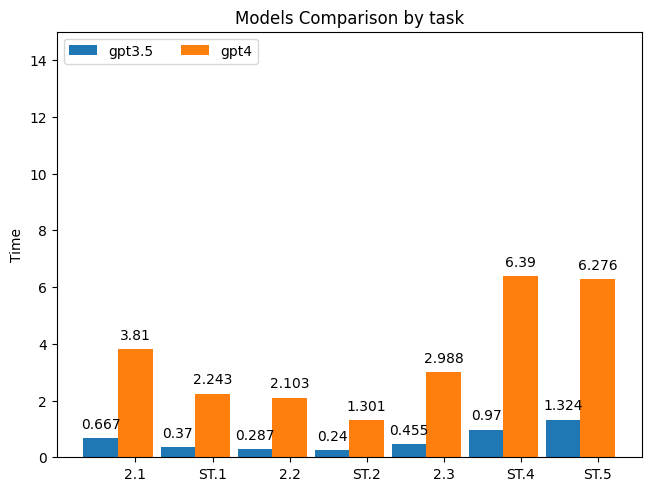

In [22]:

import matplotlib.pyplot as plt
import numpy as np

## Convert task column from pricing dataframe to tuple 
tasks = tuple(pricing[pricing['model']=='gpt4']['task'].values.tolist())

## Create a dictionary to store pricings in a tuple grouped by model
model_time = {}
for model in pricing['model'].unique():
    model_time[model] = tuple(pricing[pricing['model']==model]['time'].values.tolist())


x = np.arange(len(tasks))  # the label locations
width = 0.45  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in model_time.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time')
ax.set_title('Models Comparison by task')
ax.set_xticks(x + width, tasks)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0, 15)

plt.show()




### 2.4 Generate Nick Names

#### Student Challenge #7:
Use different models to create nick names for players from examples words. Compare different model performance. (You can set the temperature value high to increase randomness and more innovative responses.)

Player description: The champion of Men's 100 metre freestyle swimming. Seed words: fast, strong, talented.Nick names: Swimming Genius, Dark Horse, 100-Metre-Freestyle Killer

Player description: The champion of Women Figure Skating. Seed words: elegant, talented, soft.

In [23]:
# your code:

#### Model Comparison
|Model| Performance  |Time|Tokens|Pricing |
|---|---|---|---|---|
|GPT-3.5|||||
|GPT-4||||||




### 2.5 Embeddings
This section focuses on how to retrieve embeddings using different embedding models, and find similarity between documents. 

#### Student Challenge #8:
Compare the summaries of two swimming games at the 2020 Summer Olympics using the data provided below.

See whether there are differences using different embedding models to compare.

In [37]:
from openai.embeddings_utils import get_embedding, cosine_similarity

In [38]:
import pandas as pd
game_summary = [
    "The mixed 100 metre medley relay event at the 2020 Summer Olympics was held in 2021 at the Tokyo Aquatics Centre. These Games marked the first time to feature a mixed-gender swimming event in the program. Each 4-person team features two male and two female swimmers in no particular order. The medals for the competition were presented by Kirsty Coventry IOC Executive Board Member, Zimbabwe; Olympian, 2 Gold Medals, 4 Silver Medals, 1 Bronze Medal, and the medalists bouquets were presented by Errol Clarke, FINA Bureau Member; Barbados.",
    "The men's 200 metre breaststroke event at the 2020 Summer Olympics was held from 27 to 29 July 2021 at the Tokyo Aquatics Centre. It was the event's twenty-sixth consecutive appearance, having been held at every edition since 1908."
]

game_highlight = [
    'The 2020 Summer Olympics featured the first ever mixed-gender swimming event, the 100 metre medley relay. Medals were presented by Kirsty Coventry and bouquets by Errol Clarke.',
    "The men's 200 metre breaststroke event was held at the 2020 Summer Olympics in Tokyo, making it the event's 26th consecutive appearance since 1908."
]

olympics_game_df = pd.DataFrame({"summary":game_summary, "qualification":game_highlight})

olympics_game_df.head()   

,summary,qualification
0,The mixed 100 metre medley relay event at the ...,The 2020 Summer Olympics featured the first ev...
1,The men's 200 metre breaststroke event at the ...,The men's 200 metre breaststroke event was hel...


In [39]:
@timer
def get_embedding(text, model=chat_model):
    response = openai.Embedding.create(
        input=text,
        engine=model
    )
    return response["data"][0]["embedding"]

#### Model Comparison
|Model| Performance  |Time|
|---|---|---|
|GPT-3.5|||
|GPT-4|||


In [54]:
 olympics_game_df['summary'].apply(lambda x : get_embedding(x, model = 'lrbf_text_emb_ada_002'))

Finished 'get_embedding' in 0.076 secs
Finished 'get_embedding' in 0.055 secs


0    (-0.012683137319982052, -0.002773204119876027,...
1    (-0.014485535211861134, -0.0001204303771373815...
Name: summary, dtype: object